<p>In this notebook, we'll see how to fine-tune a NLLB-200 machine translation model for a new language.</p>
<p><a href="https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865">https://cointegrated.medium.com/how-to-fine-tune-a-nllb-200-model-for-translating-a-new-language-a37fc706b865</a></p>

# 0. Preliminaries

Installing dependencies:
* `transformers`, as a neural network framework
* `sentencepiece`, a backend for my tokenizer (the algorithm for converting a text into symbols from the model's vocabulary)
* `sacremoses`, a package required for text preprocessing with which NLLB models were pretrained.
* `sacrebleu`, a package for evaluating translation models

In [1]:
CUDA_CORE=1
# MODEL_USED="facebook/nllb-200-distilled-600M"
MODEL_USED="facebook/nllb-200-1.3B"
# MODEL_USED="facebook/nllb-200-3.3B"
MODEL_SAVE_PATH="models/nllb_quechua_esp_v4_1_3B"
LANGUAGE_ORIGIN_LABEL="spa_Latn"
LANGUAGE_TARGET_LABEL="quechua_Latn"
LANGUAGE_SIMILAR_LABEL="ayr_Latn" # Central Aymara
LANGUAGE_FILE="data/ALL.csv"
LANGUAGE_FILE_ORIGIN_LABEL="esp"
LANGUAGE_FILE_TARGET_LABEL="quechua"
NORMALIZER_LANGUAGE="es"
!mkdir -p {MODEL_SAVE_PATH}

In [2]:
import locale
def gpe(x=None):
    return "UTF-8"
locale.getpreferredencoding = gpe

In [3]:
!pip install sentencepiece transformers==4.33 datasets sacremoses sacrebleu  -q

In [4]:
!pip install ipywidgets

In [5]:
!pip install scikit-learn
import pandas as pd
from sklearn.model_selection import train_test_split

<h1 id="1.-Exploring-the-data">1. Exploring the data</h1>
<p>&nbsp;</p>

In [6]:
trans_df = pd.read_csv(LANGUAGE_FILE)
print(trans_df.shape)
print(trans_df.columns)

(249755, 2)
Index(['esp', 'quechua'], dtype='object')


In [7]:
df_train, df_devtest = train_test_split(trans_df, test_size=0.2, random_state=42)
df_dev, df_test = train_test_split(df_devtest, test_size=0.5, random_state=42)

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199804 entries, 46337 to 121958
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   esp      199804 non-null  object
 1   quechua  199804 non-null  object
dtypes: object(2)
memory usage: 4.6+ MB


In [9]:
df_train.head()

,esp,quechua
46337,¿Siguió Josué los consejos que recibió de Jehová?,¿Kasukurqachu Josueyqa Jehová Diospa nisqanta?
65250,"En particular, los siervos de Dios que entabla...",Astawanraqmi respetanakunanku casarakunankupaq...
13897,"Empieza por seis meses, por ejemplo.",Ichapas puntataqa kallpanchakuwaq suqta killata.
84690,Primero dedicó tiempo a conocer las necesidade...,"Puntataqa, sapakama imayna sasachakuyniyoq kas..."
100256,Este número de La Atalaya muestra cómo cumplir...,Kay Willakuq qillqam yachachichkan imaynata Di...


In [10]:
df_dev.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24975 entries, 105644 to 119642
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   esp      24975 non-null  object
 1   quechua  24975 non-null  object
dtypes: object(2)
memory usage: 585.4+ KB


In [11]:
df_dev.head()

,esp,quechua
105644,Por eso entendemos que la historia de las diez...,Chaymi entiendenchik chunka doncellakunamanta ...
79811,"Ustedes, los jóvenes, deben tener cuidado a la...",Manataqmi allinchu kanman wiñaymasikikunapa tu...
174105,Cuando una amiga de la escuela la invitó a su ...,¿Yacharqankichu chhayna fiestapi Bautizaq Juan...
113062,Los ancianos trabajan mucho por la congregació...,Ancianokunaqa iñiqmasinkunata yanapanankupaqmi...
132644,El aguante de Abrahán tuvo una poderosa influe...,Abrahanpa qaqa sayasqanmi churin Isaacta yanap...


In [12]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24976 entries, 236681 to 108081
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   esp      24976 non-null  object
 1   quechua  24976 non-null  object
dtypes: object(2)
memory usage: 585.4+ KB


In [13]:
df_test.head()

,esp,quechua
236681,Jesús sabía que sus discípulos serían felices ...,Jesusqa yacharqanmi qatikuqninkuna tukuy sonqo...
63876,“¿Nos ama Jehová aunque seamos indígenas? ”,‘ ¿Kuyawankuchu Jehová Diosqa kay llaqtamanta ...
3464,Hormiguita.,Sisichamanta.
225635,Es una recopilación de 66 libros sagrados.,Bibliapiqa 66 librokunan kan.
92762,¿Está mal disciplinar a los hijos?,¿Allinchu kanman warmakunata corregiyqa?


# 2. How well does the data fit into a NLLB tokenizer?

In [14]:
from transformers import NllbTokenizer
from tqdm.auto import tqdm, trange

In [15]:
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)

In [16]:
import re

def word_tokenize(text):
    # a very naive word tokenizer for languages with English-like orthography
    return re.findall('(\w+|[^\w\s])', text)

In [17]:
smpl = df_train.sample(10000, random_state=42, replace=True)

smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_toks'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(tokenizer.tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_toks'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(tokenizer.tokenize)

smpl[LANGUAGE_FILE_ORIGIN_LABEL + '_words'] = smpl[LANGUAGE_FILE_ORIGIN_LABEL].apply(word_tokenize)
smpl[LANGUAGE_FILE_TARGET_LABEL + '_words'] = smpl[LANGUAGE_FILE_TARGET_LABEL].apply(word_tokenize)

In [18]:
smpl.sample(5)[[LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_toks']]

,esp,esp_words,esp_toks,quechua,quechua_words,quechua_toks
248362,a) ¿Qué oportunidad tiene todavía la gente mala?,"[a, ), ¿, Qué, oportunidad, tiene, todavía, la...","[▁a, ), ▁¿, Qué, ▁oportunidad, ▁tiene, ▁todaví...",a) ¿Atinkumanraqchu millay runakuna cambiayta?,"[a, ), ¿, Atinkumanraqchu, millay, runakuna, c...","[▁a, ), ▁¿, At, ink, uman, raq, chu, ▁mil, lay..."
184085,"13, 14. a) ¿Qué debemos recordar cuando hay un...","[13, ,, 14, ., a, ), ¿, Qué, debemos, recordar...","[▁13,, ▁14., ▁a, ), ▁¿, Qué, ▁debemos, ▁record...","13, 14. a) ¿Imatan umallikuna yuyarinanku cris...","[13, ,, 14, ., a, ), ¿, Imatan, umallikuna, yu...","[▁13,, ▁14., ▁a, ), ▁¿, I, matan, ▁um, al, lik..."
237163,"Cuando sabemos cosas confidenciales, no debemo...","[Cuando, sabemos, cosas, confidenciales, ,, no...","[▁Cuando, ▁sabemos, ▁cosas, ▁conf, idencia, le...",Chaymantapas mana willanakunata yachaspaqa man...,"[Chaymantapas, mana, willanakunata, yachaspaqa...","[▁Chaymanta, pas, ▁mana, ▁wil, lan, akunata, ▁..."
178597,Nunca nos han faltado las “otras cosas ” que J...,"[Nunca, nos, han, faltado, las, “, otras, cosa...","[▁Nunca, ▁nos, ▁han, ▁falt, ado, ▁las, ▁, “, o...",Manan hayk’aqpas ima necesitasqaykupas faltawa...,"[Manan, hayk, ’, aqpas, ima, necesitasqaykupas...","[▁Man, an, ▁hay, k, ’, aq, pas, ▁ima, ▁necesit..."
66852,"Después de crear a nuestros primeros padres, J...","[Después, de, crear, a, nuestros, primeros, pa...","[▁Después, ▁de, ▁crear, ▁a, ▁nuestros, ▁primer...",Adantawan Evata unancharuspanmi Jehová Dios ni...,"[Adantawan, Evata, unancharuspanmi, Jehová, Di...","[▁Adan, tawan, ▁Ev, ata, ▁unan, char, us, pan,..."


In [19]:
stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()
stats

/tmp/ipykernel_269874/105503015.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  stats = smpl[[LANGUAGE_FILE_ORIGIN_LABEL + '_toks', LANGUAGE_FILE_TARGET_LABEL + '_toks', LANGUAGE_FILE_ORIGIN_LABEL + '_words', LANGUAGE_FILE_TARGET_LABEL + '_words']].applymap(len).describe()


,esp_toks,quechua_toks,esp_words,quechua_words
count,10000.000000,10000.00000,10000.000000,10000.000000
mean,22.702100,24.46740,18.266300,12.481600
std,12.815638,13.92004,10.228384,7.437513
min,1.000000,1.00000,1.000000,1.000000
25%,14.000000,15.00000,11.000000,7.000000
50%,21.000000,22.00000,17.000000,11.000000
75%,29.000000,31.00000,24.000000,16.000000
max,110.000000,140.00000,94.000000,71.000000


In [20]:
print(stats[LANGUAGE_FILE_ORIGIN_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_ORIGIN_LABEL + "_words"]['mean'])
print(stats[LANGUAGE_FILE_TARGET_LABEL + "_toks"]['mean'] / stats[LANGUAGE_FILE_TARGET_LABEL + "_words"]['mean'])

1.2428406409617712
1.9602775285219844


In [21]:
print(tokenizer.unk_token, tokenizer.unk_token_id)

<unk> 3


<p>One more check: how often does the token happen in the tokenizer output for quechua? If this is too often, we need to fix it somehow</p>

In [22]:
texts_with_unk = [text for text in tqdm(trans_df[LANGUAGE_FILE_TARGET_LABEL]) if tokenizer.unk_token_id in tokenizer(text).input_ids]
print(len(texts_with_unk))

  0%|          | 0/249755 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (3857 > 1024). Running this sequence through the model will result in indexing errors


72814


In [23]:
import random
s = random.sample(texts_with_unk, 5)
s

['Estudioykipi, llank’anaykipi compañeroykikunawan kashaspaqa kallpachakunkichá Diospa kamachisqanman hinapuni imatapas ruwanaykipaq.',
 'Hinaptinmi, Jehova Diosqa willakuq Jehuta kamachirqa mana allin tanteasqanmanta Josafatta anyananpaq hinaspa kaynata ninanpaq: ‘ Ichaqa qanmi ruwarqanki allinkunata ’, nispa (2 Cron. 18: 4, 5, 14 - 22, 33, 34; 19: 1 - 3).',
 'Biblianchista t’ikranankupaqqa ñawpa hebreo qelqakunatan utilizarqanku, Kachi qochapi tarisqanku k’uyukunaqa 1.000 wata ñawpaqtaraqmi qelqakusqa.',
 'Hukmanyasqa kanaymantaqa imapas allin kaqkunapi yuyaymananaypaqmi kallpanchakuni ”, nispa.',
 'Yaqa llapa runakunan Satanaspa munasqanta ruwanku manataqmi Diosta Kamachiqninkuta hinachu qhawarinku. Chhaynapin Saqra ‘ kay pachapi kamachikuq qollanaman ’ tukupun.']

In [24]:
# this code is adapted from  the Stopes repo of the NLLB team
# https://github.com/facebookresearch/stopes/blob/main/stopes/pipelines/monolingual/monolingual_line_processor.py#L214

import re
import sys
import typing as tp
import unicodedata
from sacremoses import MosesPunctNormalizer


mpn = MosesPunctNormalizer(lang=NORMALIZER_LANGUAGE)
mpn.substitutions = [
    (re.compile(r), sub) for r, sub in mpn.substitutions
]


def get_non_printing_char_replacer(replace_by: str = " ") -> tp.Callable[[str], str]:
    non_printable_map = {
        ord(c): replace_by
        for c in (chr(i) for i in range(sys.maxunicode + 1))
        # same as \p{C} in perl
        # see https://www.unicode.org/reports/tr44/#General_Category_Values
        if unicodedata.category(c) in {"C", "Cc", "Cf", "Cs", "Co", "Cn"}
    }

    def replace_non_printing_char(line) -> str:
        return line.translate(non_printable_map)

    return replace_non_printing_char

replace_nonprint = get_non_printing_char_replacer(" ")

def preproc(text):
    clean = mpn.normalize(text)
    clean = replace_nonprint(clean)
    # replace 𝓕𝔯𝔞𝔫𝔠𝔢𝔰𝔠𝔞 by Francesca
    clean = unicodedata.normalize("NFKC", clean)
    return clean

In [25]:
texts_with_unk_normed = [text for text in tqdm(texts_with_unk) if tokenizer.unk_token_id in tokenizer(preproc(text)).input_ids]
print(len(texts_with_unk_normed))

  0%|          | 0/72814 [00:00<?, ?it/s]

0


<h1 id="3.-Adding-a-new-language-tag-to-the-tokenizer-and-model">3. Expanding the vocabulary</h1>

In [26]:
from collections import Counter
all_texts = trans_df[LANGUAGE_FILE_TARGET_LABEL]
all_text_normalized = [preproc(t) for t in tqdm(all_texts)]
chars_cnt = Counter(c for t in all_text_normalized for c in t)
required_chars = ''.join([
    k for k, v in chars_cnt.most_common() 
    if v >= 3 and k not in ' '
])

  0%|          | 0/249755 [00:00<?, ?it/s]

In [27]:
all_texts_file = MODEL_SAVE_PATH + "/all_texts_file.csv"
trans_df[LANGUAGE_FILE_TARGET_LABEL].to_csv(all_texts_file, sep='|', index=False, header=False)

In [28]:
import sentencepiece as spm

SPM_PREFIX = MODEL_SAVE_PATH + '/spm_16k'
with open(all_texts_file, 'w') as f:
    for i, text in enumerate(all_texts):
        print(text, file=f)

spm.SentencePieceTrainer.train(
    input=all_texts_file,
    model_prefix=SPM_PREFIX,
    vocab_size=2**13,  # 16K
    character_coverage = 1,
    num_threads=16,
    train_extremely_large_corpus=False,
    add_dummy_prefix=False,
    max_sentencepiece_length=128,
    max_sentence_length=4192*4,
    pad_id=0,
    eos_id=1,
    unk_id=2,
    bos_id=-1,
    required_chars=required_chars,
)

sentencepiece_trainer.cc(78) LOG(INFO) Starts training with : 
trainer_spec {
  input: models/nllb_quechua_esp_v4_1_3B/all_texts_file.csv
  input_format: 
  model_prefix: models/nllb_quechua_esp_v4_1_3B/spm_16k
  model_type: UNIGRAM
  vocab_size: 8192
  self_test_sample_size: 0
  character_coverage: 1
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 16768
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 128
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  pretokenization_delimiter: 
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: aniuksqhptmycrloew.,ñD'd"IbJvC:1?¿AgPá)2SM(jKB-3fH0T4NE5RQ9LYW678zUGí;][Ñxóé!¡OúF•/V*▪ÉÁZ□ˈ|◆Í>ÓXʼüè%●·$Úö▸ä©æ◇○✔łãה°ý←☞àנפשׁ→Š↓żëøåי↑çů
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  seed_sentencepieces_file: 
  hard_vocab_limit: 

In [29]:
!pip install protobuf==3.19.4

In [30]:
!wget https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py -O /home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py

--2024-03-09 15:23:18--  https://raw.githubusercontent.com/protocolbuffers/protobuf/main/python/google/protobuf/internal/builder.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4082 (4.0K) [text/plain]
Saving to: ‘/home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py’

/home/americasnlp/u 100%[===================>]   3.99K  --.-KB/s    in 0s      

2024-03-09 15:23:18 (110 MB/s) - ‘/home/americasnlp/uniandes/lib/python3.10/site-packages/google/protobuf/internal/builder.py’ saved [4082/4082]



In [31]:
from sentencepiece import sentencepiece_model_pb2 as sp_pb2_model
# At this step, the code may throw an error about protobuf. Do as it tells.
from transformers import NllbTokenizer

# reading the NLLB and the Tyvan sentencepiece models into a native format
tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
sp_trained = spm.SentencePieceProcessor(model_file=f'{SPM_PREFIX}.model')
added_spm = sp_pb2_model.ModelProto()
added_spm.ParseFromString(sp_trained.serialized_model_proto())
old_spm = sp_pb2_model.ModelProto()
old_spm.ParseFromString(tokenizer.sp_model.serialized_model_proto())

# adding the missing tokens to the NLLB sentencepiece model
nllb_tokens_set = {p.piece for p in old_spm.pieces}
prev_min_score = old_spm.pieces[-1].score
for p in added_spm.pieces:
    piece = p.piece
    if piece not in nllb_tokens_set:
        new_p = sp_pb2_model.ModelProto().SentencePiece()
        new_p.piece = piece
        # for all new tokens, I'll set a lower score (priority)
        new_p.score = p.score + prev_min_score
        old_spm.pieces.append(new_p)

# saving the result to disk
NEW_SPM_NAME = MODEL_SAVE_PATH + '/spm_nllb_268k.model'
with open(NEW_SPM_NAME, 'wb') as f:
    f.write(old_spm.SerializeToString())

In [32]:
from transformers import AutoModelForSeq2SeqLM
model_name = MODEL_USED

# loading the tokenizers
tokenizer_old = NllbTokenizer.from_pretrained(model_name)
tokenizer = NllbTokenizer.from_pretrained(model_name, vocab_file=NEW_SPM_NAME)
print(len(tokenizer_old), len(tokenizer)) # 256204, 268559
added_vocab = set(tokenizer.get_vocab()).difference(set(tokenizer_old.get_vocab()))
print(len(added_vocab))  # 12355

# loading and resizing the model
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
model.resize_token_embeddings(len(tokenizer))

# re-initializing the new embeddings
for t in tqdm(added_vocab):
    tt = tokenizer_old(t, add_special_tokens=False).input_ids
    if len(tt) == 0:
        tt = [tokenizer_old.unk_token_id]
    idx = tokenizer.convert_tokens_to_ids(t)
    model.model.shared.weight.data[idx] = model.model.shared.weight.data[tt].mean(0)

256204 262578
6373


2024-03-09 15:23:21.541112: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-09 15:23:21.678845: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-09 15:23:22.303121: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-09 15:23:22.303181: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] 

  0%|          | 0/6373 [00:00<?, ?it/s]

<h1 id="4.-Adding-a-new-language-tag-to-the-tokenizer-and-model">4. Adding a new language tag to the tokenizer and model</h1>

In [33]:
from transformers import AutoModelForSeq2SeqLM
from transformers import NllbTokenizer

In [34]:
print(len(tokenizer))
print(tokenizer.convert_ids_to_tokens([256202 + len(added_vocab) + 1, 256203 + len(added_vocab) + 1]))

262578
['zul_Latn', '<mask>']


In [35]:
# tokenizer = NllbTokenizer.from_pretrained(MODEL_USED)
# print(len(tokenizer))
# print(tokenizer.convert_ids_to_tokens([256202, 256203]))

In [36]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """
    Add a new language token to the tokenizer vocabulary
    (this should be done each time after its initialization)
    """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [37]:
fix_tokenizer(tokenizer)

In [38]:
print(tokenizer.convert_ids_to_tokens([256202 + len(added_vocab) + 1, 256202 + len(added_vocab) + 2, 256202 + len(added_vocab) + 3])) # ['zul_Latn', LANGUAGE_TARGET_LABEL, '<mask>']
print(tokenizer.convert_tokens_to_ids(['zul_Latn', LANGUAGE_TARGET_LABEL, '<mask>'])) # [256202, 256203, 256204]
# this is consistent now, wow!

['zul_Latn', 'quechua_Latn', '<mask>']
[262576, 262577, 262578]


In [39]:
added_token_id = tokenizer.convert_tokens_to_ids(LANGUAGE_TARGET_LABEL)
similar_lang_id = tokenizer.convert_tokens_to_ids(LANGUAGE_SIMILAR_LABEL)
print(added_token_id, similar_lang_id)

262577 262392


In [40]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_USED)
model.resize_token_embeddings(len(tokenizer))

You are resizing the embedding layer without providing a `pad_to_multiple_of` parameter. This means that the new embedding dimension will be 262579. This might induce some performance reduction as *Tensor Cores* will not be available. For more details about this, or help on choosing the correct value for resizing, refer to this guide: https://docs.nvidia.com/deeplearning/performance/dl-performance-matrix-multiplication/index.html#requirements-tc


Embedding(262579, 1024)

In [41]:
# moving the embedding for "mask" to its new position
model.model.shared.weight.data[added_token_id+1] = model.model.shared.weight.data[added_token_id]
# initializing new language token with a token of a similar language
model.model.shared.weight.data[added_token_id] = model.model.shared.weight.data[similar_lang_id]

<h1 id="5.-Preparing-the-training-loop">5. Preparing the training loop</h1>

In [42]:
import gc
import random
import numpy as np
import torch
from tqdm.auto import tqdm, trange
from transformers.optimization import Adafactor
from transformers import get_constant_schedule_with_warmup

def cleanup():
    """Try to free GPU memory"""
    gc.collect()
    torch.cuda.empty_cache()

cleanup()

In [43]:
model.cuda(CUDA_CORE);

In [44]:
optimizer = Adafactor(
    [p for p in model.parameters() if p.requires_grad],
    scale_parameter=False,
    relative_step=False,
    lr=1e-4,
    clip_threshold=1.0,
    weight_decay=1e-3,
)

In [45]:
batch_size = 16  # 32 already doesn't fit well to 15GB of GPU memory
max_length = 128
warmup_steps = 1000
training_steps = 57000

In [46]:
losses = []
scheduler = get_constant_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps)

In [47]:
LANGS = [(LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_ORIGIN_LABEL), (LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_TARGET_LABEL)]

def get_batch_pairs(batch_size, data=df_train):
    (l1, long1), (l2, long2) = random.sample(LANGS, 2)
    xx, yy = [], []
    for _ in range(batch_size):
        item = data.iloc[random.randint(0, len(data)-1)]
        xx.append(preproc(item[l1]))
        yy.append(preproc(item[l2]))
    return xx, yy, long1, long2

print(get_batch_pairs(1))

(['Pablo nos explica luego cuáles son las características del amor y cuáles no (léase 1 Corintios 13: 4 - 8).'], ['Pablom willawanchik kuyakuyniyoqpa imakuna rurananta hinaspa mana ruranantapas (leey 1 Corintios 13: 4 - 8).'], 'spa_Latn', 'quechua_Latn')


<h1 id="6.-The-training-loop">6. The training loop</h1>

In [48]:
model.train()
x, y, loss = None, None, None
cleanup()

tq = trange(len(losses), training_steps)
for i in tq:
    xx, yy, lang1, lang2 = get_batch_pairs(batch_size)
    try:
        tokenizer.src_lang = lang1
        x = tokenizer(xx, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        tokenizer.src_lang = lang2
        y = tokenizer(yy, return_tensors='pt', padding=True, truncation=True, max_length=max_length).to(model.device)
        y.input_ids[y.input_ids == tokenizer.pad_token_id] = -100

        loss = model(**x, labels=y.input_ids).loss
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        optimizer.zero_grad(set_to_none=True)
        scheduler.step()

    except RuntimeError as e:
        optimizer.zero_grad(set_to_none=True)
        x, y, loss = None, None, None
        cleanup()
        print('error', max(len(s) for s in xx + yy), e)
        continue

    if i % 1000 == 0:
        print(i, np.mean(losses[-1000:]))

    if i % 1000 == 0 and i > 0:
        model.save_pretrained(MODEL_SAVE_PATH)
        tokenizer.save_pretrained(MODEL_SAVE_PATH)

  0%|          | 0/57000 [00:00<?, ?it/s]

0 4.960761547088623
1000 3.9889893584251404
2000 2.8673328433036804
3000 2.6630357538461684
4000 2.5087757760286333
5000 2.354465537309647
6000 2.2464005426168443
7000 2.175799322247505
8000 2.0919856976270674
9000 2.0688853011131285
10000 1.9964972884655
11000 1.9520112721920013
12000 1.9051693674325942
13000 1.857537037730217
14000 1.835550474345684
15000 1.784533957719803
16000 1.7504330751895905
17000 1.712189292907715
18000 1.6834085344076157
19000 1.6501225084662436
20000 1.619278488755226
21000 1.6043200800418853
22000 1.594289392232895
23000 1.547661446273327
24000 1.543802491605282
25000 1.504034716308117
26000 1.4981561534404755
27000 1.4633091015219688
28000 1.4378192024827003
29000 1.4313343473672866
30000 1.4064960139989853
31000 1.3856973029971122
32000 1.3643365386128425
33000 1.3671620355844498
34000 1.3394596788287163
35000 1.3339828330874444
36000 1.3222059993743895
37000 1.2977528787851333
38000 1.288164120733738
39000 1.2842322872281076
40000 1.2728292793035507
4100

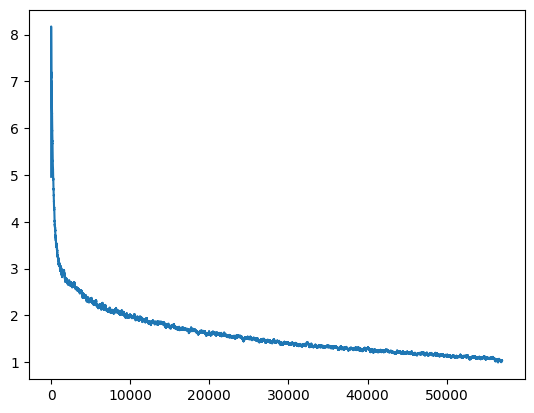

In [49]:
pd.Series(losses).ewm(100).mean().plot();

In [50]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=16, b=1.5, max_input_length=1024, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        **kwargs
    )
    #print(inputs.input_ids.shape[1], result.shape[1])
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [51]:
xx, yy, lang1, lang2 = get_batch_pairs(1, data=df_dev)
print(xx)
print(yy)
model.eval()
print(translate(xx[0], lang1, lang2, no_repeat_ngram_size=3, num_beams=5))

['¿Cómo es esto posible?']
['¿Imaynataq chayqa kanman?']
['¿Imaynapin chhaynapi tarikusunman?']


In [52]:
!ls -alsh $MODEL_SAVE_PATH

total 5.2G
4.0K drwxrwxr-x  2 americasnlp americasnlp 4.0K Mar  9 15:36 .
4.0K drwxr-xr-x 10 americasnlp americasnlp 4.0K Mar  9 15:35 ..
 22M -rw-rw-r--  1 americasnlp americasnlp  22M Mar  9 15:22 all_texts_file.csv
4.0K -rw-rw-r--  1 americasnlp americasnlp  848 Mar 10 02:35 config.json
4.0K -rw-rw-r--  1 americasnlp americasnlp  184 Mar 10 02:35 generation_config.json
5.2G -rw-rw-r--  1 americasnlp americasnlp 5.2G Mar 10 02:35 pytorch_model.bin
4.8M -rw-rw-r--  1 americasnlp americasnlp 4.8M Mar 10 02:35 sentencepiece.bpe.model
4.0K -rw-rw-r--  1 americasnlp americasnlp 3.5K Mar 10 02:35 special_tokens_map.json
384K -rw-rw-r--  1 americasnlp americasnlp 382K Mar  9 15:23 spm_16k.model
160K -rw-rw-r--  1 americasnlp americasnlp 157K Mar  9 15:23 spm_16k.vocab
4.8M -rw-rw-r--  1 americasnlp americasnlp 4.8M Mar  9 15:23 spm_nllb_268k.model
4.0K -rw-rw-r--  1 americasnlp americasnlp  570 Mar 10 02:35 tokenizer_config.json


<h1 id="7.-Using-the-model">7. Testing the model</h1>

In [53]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import NllbTokenizer, AutoModelForSeq2SeqLM, AutoConfig
from tqdm.auto import tqdm, trange

In [54]:
def fix_tokenizer(tokenizer, new_lang=LANGUAGE_TARGET_LABEL):
    """ Add a new language token to the tokenizer vocabulary (this should be done each time after its initialization) """
    old_len = len(tokenizer) - int(new_lang in tokenizer.added_tokens_encoder)
    tokenizer.lang_code_to_id[new_lang] = old_len-1
    tokenizer.id_to_lang_code[old_len-1] = new_lang
    # always move "mask" to the last position
    tokenizer.fairseq_tokens_to_ids["<mask>"] = len(tokenizer.sp_model) + len(tokenizer.lang_code_to_id) + tokenizer.fairseq_offset

    tokenizer.fairseq_tokens_to_ids.update(tokenizer.lang_code_to_id)
    tokenizer.fairseq_ids_to_tokens = {v: k for k, v in tokenizer.fairseq_tokens_to_ids.items()}
    if new_lang not in tokenizer._additional_special_tokens:
        tokenizer._additional_special_tokens.append(new_lang)
    # clear the added token encoder; otherwise a new token may end up there by mistake
    tokenizer.added_tokens_encoder = {}
    tokenizer.added_tokens_decoder = {}

In [55]:
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_SAVE_PATH).cuda(CUDA_CORE)
tokenizer = NllbTokenizer.from_pretrained(MODEL_SAVE_PATH)
fix_tokenizer(tokenizer)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [56]:
def translate(text, src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL, a=32, b=3, max_input_length=1024, num_beams=4, **kwargs):
    tokenizer.src_lang = src_lang
    tokenizer.tgt_lang = tgt_lang
    inputs = tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=max_input_length)
    result = model.generate(
        **inputs.to(model.device),
        forced_bos_token_id=tokenizer.convert_tokens_to_ids(tgt_lang),
        max_new_tokens=int(a + b * inputs.input_ids.shape[1]),
        num_beams=num_beams,
        **kwargs
    )
    return tokenizer.batch_decode(result, skip_special_tokens=True)

In [57]:
t = "las canciones de amor me gustan mucho"
print(translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL))

['Iñiqmasinchikmanta takikunaqa ancha allinmi ñuqapaqqa']


In [58]:
translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['chan chan waylawaytaqa harawmi ancha chiqaqmi takita kusichiwan']

In [59]:
t = "kuyakuyllawan takitam anchata kuyani"
print(translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL))

['amo la música con amor']


In [60]:
translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL, do_sample=True, num_beams=1, temperature=1.5)

['le doy tanto énfasis a la música']

In [61]:
def batched_translate(texts, batch_size=8, **kwargs):
    """Translate texts in batches of similar length"""
    idxs, texts2 = zip(*sorted(enumerate(texts), key=lambda p: len(p[1]), reverse=True))
    results = []
    for i in trange(0, len(texts2), batch_size):
        results.extend(translate(texts2[i: i+batch_size], **kwargs))
    return [p for i, p in sorted(zip(idxs, results))]

In [62]:
# df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = batched_translate(df_test["LANGUAGE_FILE_TARGET_LABEL"], src_lang=LANGUAGE_TARGET_LABEL, tgt_lang=LANGUAGE_ORIGIN_LABEL)
# df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = batched_translate(df_test["LANGUAGE_FILE_ORIGIN_LABEL"], src_lang=LANGUAGE_ORIGIN_LABEL, tgt_lang=LANGUAGE_TARGET_LABEL)

In [63]:
df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'] = [translate(t, LANGUAGE_TARGET_LABEL, LANGUAGE_ORIGIN_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_TARGET_LABEL])]
df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'] = [translate(t, LANGUAGE_ORIGIN_LABEL, LANGUAGE_TARGET_LABEL)[0] for t in tqdm(df_test[LANGUAGE_FILE_ORIGIN_LABEL])]

  0%|          | 0/24976 [00:00<?, ?it/s]

  0%|          | 0/24976 [00:00<?, ?it/s]

In [64]:
import sacrebleu
bleu_calc = sacrebleu.BLEU()
chrf_calc = sacrebleu.CHRF(word_order=2)  # this metric is called ChrF++

In [65]:
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_ORIGIN_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_ORIGIN_LABEL].tolist()]))
print(bleu_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))
print(chrf_calc.corpus_score(df_test[LANGUAGE_FILE_TARGET_LABEL + '_translated'].tolist(), [df_test[LANGUAGE_FILE_TARGET_LABEL].tolist()]))

BLEU = 21.36 48.8/26.3/18.3/13.4 (BP = 0.901 ratio = 0.906 hyp_len = 405173 ref_len = 447315)
chrF2++ = 39.00
BLEU = 9.40 33.4/11.7/6.5/4.4 (BP = 0.913 ratio = 0.917 hyp_len = 273142 ref_len = 297933)
chrF2++ = 37.28


In [66]:
pd.options.display.max_colwidth = 100

In [67]:
df_test.sample(10, random_state=42)[[LANGUAGE_FILE_TARGET_LABEL, LANGUAGE_FILE_ORIGIN_LABEL, LANGUAGE_FILE_TARGET_LABEL + '_translated', LANGUAGE_FILE_ORIGIN_LABEL + '_translated']]

,quechua,esp,quechua_translated,esp_translated
12982,Necesitasqallaykichikpi gastaychik.,Hagan cambios.,Kausayniykichispi cambiaychis.,Dedíquense lo necesario.
36270,‘ Huk ratollapi ’ nisqanmi qawachin puchukaynin mana unay tiempopi kananmanta.,La expresión “en una sola hora ” muestra que su destrucción será relativamente rápida.,"Huk horallapi sucedenanmantan Biblia nin: ""Usqhayllan p'uchukayqa chayamunqa "", nispa.",El pronóstico de los últimos días demuestra que el fin es inminente.
77931,"Bardet runapa nisqanman hinaqa, Cristo sutiqa allintapunim tupan griego rimaypi qellqasqa kasqan...","En su análisis, Bardet declara que ese título concuerda “en todo sentido con el idioma griego, q...",Judiokunaq sutinta t'aqwirispan Bardet runa willarqan griego simipi chay suti kaqllapuni kasqanta.,"Bardet señala que el término griego que se traduce ""cristo "" encaja bastante bien con el que se ..."
156122,Kallpachawananchismi allin kaqta ruwanapaq allin runa kananchispaqpas.,"Además, debe sacar lo mejor de cada uno de nosotros y darnos fuerzas para hacer lo que está bien.","Hinaspapas allinninchispaqmi kanan, kallpachawanchistaqmi allin kaqta ruwananchispaq.",Deben motivarnos a hacer el bien y cultivar buenas actitudes.
119112,Chay mozoñataqmi iñiqmasinchikta nirqa paywan rimayta mana munasqanmanta.,El joven le dijo que no quería hablar con él.,Chay waynaqa manan paywan rimayta munaranchu.,El joven le dijo al hermano que no quería hablar con él.
140928,• ¿Imataq ‘ llamp’u sonqo ’ kayri?,• ¿Qué significa ser “de genio apacible ”?,• ¿Iman llamp'u sonqo kay?,• ¿Qué es la apacibilidad?
45324,Chayna mañakuymi qawachin ñoqanchikmantawan hukkunamanta ima piensasqanchikta.,Ese tipo de oraciones revelan mucho sobre nosotros y sobre la manera en que vemos a los hermanos.,Chayna mañakusqanchikmi qawachin imayna kasqanchikta hinaspa iñiqmasinchikkunata imayna qawasqan...,Dicha petición revela lo que realmente pensamos de nosotros y de los demás.
210637,"Arí, umallikunaqa ‘ michiwashallanchispunin ’ (otaq ‘ mana puñuspa almanchista qhawashanku ’, Qh...",Los ancianos están “velando por las almas ” de sus hermanos.,Umallikunaqa iñiqmasinkuq almanmantan cuentallikuchkanku.,"Así es, los ancianos siguen vigilating el rebaño de Dios, es decir, viendo sus ovejas como si no..."
193954,Ichaqa iskay semana apachisqanku qhepamanmi llapanta kutichipusqaku.,"Sin embargo, dos semanas después, el envío entero regresó a la Casa Bíblica.",Iskay semanamantaq ichaqa chay qelqakunata kutichipurqanku.,Pero después de dos semanas recibieron todos los correos.
131759,nispa pipas tapuykuqtinmi ninku: “Tayta - mamaymi chayta yachachiwaranku ” otaq“ chhaynatan yach...,"Pero si se le preguntara por qué cree en él, tal vez respondería que así lo criaron o que eso fu...","Ichaqa Diospi imanasqa iñisqanmanta tapusuptikiqa, yaqapaschá niwaq: ""Chayna tayta - mamaykimant...","Cuando alguien nos hace una pregunta, nos dice que los padres nos han enseñado que el dinero es ..."
